## Race Car Project 

In [4]:
import model as Mod
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
import shapely.geometry as sg

In [3]:
import sys
sys.path.append("C:\\Users\\Pouya\\Documents\\Deep Learning\\Project\\")

In [4]:
sys.path.append("C:\\Users\\Pouya\\Documents\\Deep Learning\\Project\\gym-Racecar\\gym_Racecar\\envs\\")

In [5]:
print(sys.path)

['C:\\Users\\Pouya\\Documents\\Deep Learning\\Project', 'C:\\Python38\\python38.zip', 'C:\\Python38\\DLLs', 'C:\\Python38\\lib', 'C:\\Python38', '', 'C:\\Users\\Pouya\\AppData\\Roaming\\Python\\Python38\\site-packages', 'C:\\Python38\\lib\\site-packages', 'c:\\users\\pouya\\documents\\deep learning\\project\\gym-racecar', 'C:\\Python38\\lib\\site-packages\\win32', 'C:\\Python38\\lib\\site-packages\\win32\\lib', 'C:\\Python38\\lib\\site-packages\\Pythonwin', 'C:\\Python38\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Pouya\\.ipython', 'C:\\Users\\Pouya\\Documents\\Deep Learning\\Project\\', 'C:\\Users\\Pouya\\Documents\\Deep Learning\\Project\\gym-Racecar\\gym_Racecar\\envs\\']


In [6]:
from racetrack import racetrack
from simulation import python_env
from environment import RacecarEnv

In [7]:
from gym import envs
import gym_Racecar

# envids = [spec.id for spec in envs.registry.all()]
# for envid in sorted(envids):
#     print(envid)

In [8]:
pip install -e gym-Racecar

Obtaining file:///C:/Users/Pouya/Documents/Deep%20Learning/Project/gym-Racecar
  Attempting uninstall: gym-Racecar
    Found existing installation: gym-Racecar 0.0.1
    Uninstalling gym-Racecar-0.0.1:
      Successfully uninstalled gym-Racecar-0.0.1
  Running setup.py develop for gym-Racecar
Note: you may need to restart the kernel to use updated packages.


In [9]:
import gym
num_turns = 5
env = gym.make('RacecarEnv-v0', turns = num_turns)
# print(env.action_space)
# print(env.observation_space)

### Policy Gradient 

In [9]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
#         self.hidden = nn.Linear(n_inputs, n_hidden)
        self.hidden = nn.Linear(n_hidden, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.D = nn.Dropout(p=0.6)

    def forward(self, x):
        x = self.hidden(x)
#         x = self.D(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [10]:
n_inputs = env.observation_space.shape[0]
n_hidden = 35
n_outputs = 2 #env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 1
action shape: 2


In [11]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

In [12]:
# training settings

num_episodes = 10
rollout_limit = 10 # max rollout length
discount_factor = 0.99 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.01 # you know this by now
val_freq = 10 # validation frequency

# Policy 
policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

In [13]:
def closer(dist1, dist2):
    return dist2 < dist1

start training


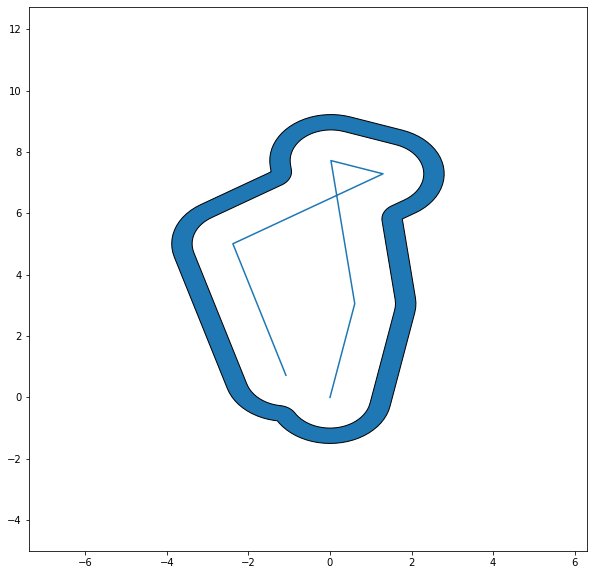

Position: ([], [], [])
Observation: Distance | Angle | Sign: 14.069916519157335 0.47715451444801765 -1


NameError: name 'a' is not defined

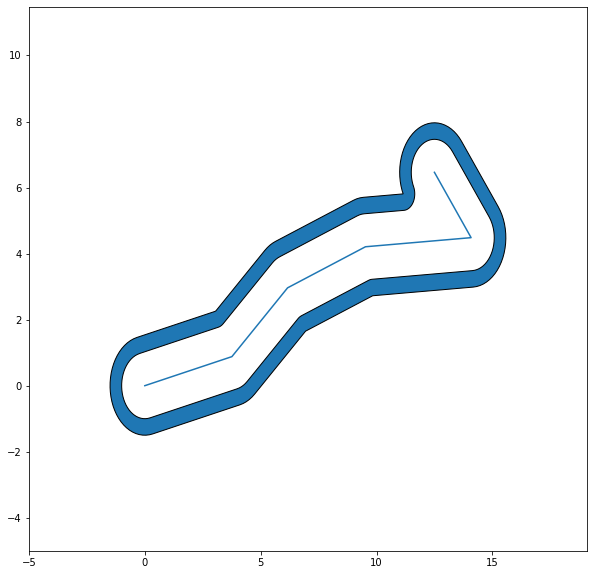

In [14]:
# train policy network
velocity = 1
steering_angle = 0
theta = []
RP = []

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        x = []
        y = []
        rollout = []
        R = racetrack(num_turns,i)
        RacePlot, Goal = R.generate()
        P = python_env(num_turns,i)
        s = env.reset(i)
        R.generate(1)
#         print(Goal[-1])
#         RacePlot, Goal = R.generate()



# PLOT TRACK:

#         track = sg.LineString(Goal)
#         outer = track.buffer(1.5)
#         inner = outer.buffer(-0.5)
#         Track = outer - inner
        xs = [a[0] for a in Goal]
        ys = [a[1] for a in Goal]
        fig = plt.figure(figsize=(10, 10))
        ax1 = fig.gca()
        ax1.set_xlim(min(xs)-5,max(xs)+5)
        ax1.set_ylim(min(ys)-5,max(ys)+5)
        ax1.plot(xs, ys)
        ax1.add_patch(PolygonPatch(RacePlot, alpha=1, zorder=2))
        print("Position:", (x,y,theta))


#         ss = s[0][:30]
#         print("\nThese are the states:\n", ss)
#         D = s[0][30:33]
#         print("\nThese are the distance, angle, sign:\n", D)
#         a = s[0][-2:]
#         print("\nThis is the action:\n", a)




        for j in range(rollout_limit):
            
            Dist,Angle,Sign = env.observe()
            print("Observation: Distance | Angle | Sign:",Dist, Angle, Sign)
            x1,y1,theta = P.kinematic(velocity, steering_angle)
            x.append(x1)
            y.append(y1)
            if closer(Angle, theta) == 1:
                steering_angle = theta
                
                env.step(a)
#                 reward = 1
                
            if closer(Dist,x[j]) == 1:
                velocity = velocity+1
                reward = 1
            else:
                velocity = velocity/2
                reward = 0
        
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
#                 print(a_prob)
            a = (np.cumsum(a_prob.numpy()) > np.random.rand()).argmax() # sample action
#             print(a)
            s1, r, done, _ = env.step([[a,a],[a,a]])
#             s1, r, done, _ = env.step(a_prob)
#             dist, phi, sign = env.observe()
#             print("Distance:", dist)
            rollout.append((s, a, r))
#             print(len(rollout[0]))
            s = s1
            if done: break
        

        ax = plt.gca()
        L2 = ax.plot(x,y, 'r--')
        L3 = ax.plot(Goal[-1][0],Goal[-1][1], 'rX',markersize= 20)
        plt.show()    
        # prepare batch
        rollout = np.array(rollout)
#         print(np.shape(rollout[0][0]))
        states = np.vstack(rollout[:,0])
#         print(np.shape(states))
        actions = np.vstack(rollout[:,1])
#         print(np.shape(actions))
        rewards = np.array(rollout[:,2], dtype=float)
        print(rewards)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset(i)
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
                    s, r, done, _ = env.step([[a,a],[a,a]])
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

# Genetic Algorithm

In [10]:
from genetic import genetic_algo as Gen

In [11]:
ga = Gen(1)
print(ga)
# ga.train(1,10,1,'test')


start training


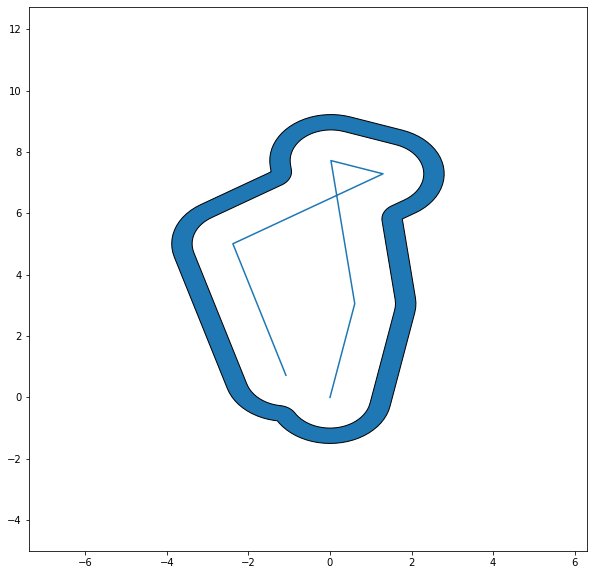

Position: ([], [], [])
Observation: Distance | Angle | Sign: 14.069916519157335 0.47715451444801765 -1


TypeError: 'int' object is not subscriptable

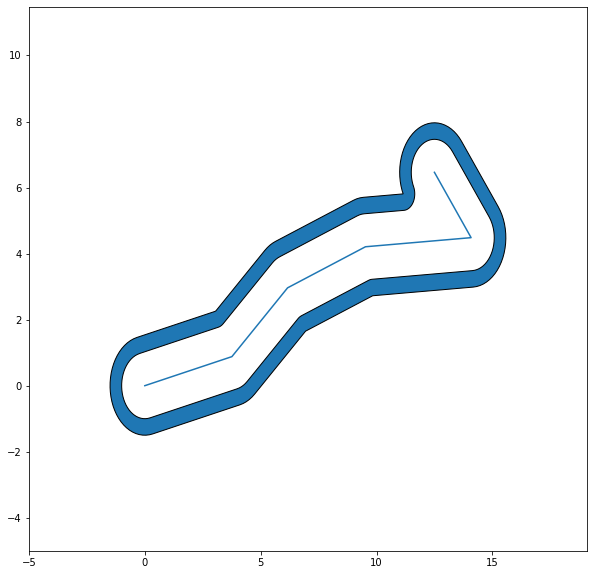

In [21]:
# train Genetic network
W
velocity = 1
steering_angle = 0
theta = []
RP = []

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        x = []
        y = []
        rollout = []
        R = racetrack(num_turns,i)
        RacePlot, Goal = R.generate()
        P = python_env(num_turns,i)
        s = env.reset(i)
        R.generate(1)
#         print(Goal[-1])
#         RacePlot, Goal = R.generate()



# PLOT TRACK:

#         track = sg.LineString(Goal)
#         outer = track.buffer(1.5)
#         inner = outer.buffer(-0.5)
#         Track = outer - inner
        xs = [a[0] for a in Goal]
        ys = [a[1] for a in Goal]
        fig = plt.figure(figsize=(10, 10))
        ax1 = fig.gca()
        ax1.set_xlim(min(xs)-5,max(xs)+5)
        ax1.set_ylim(min(ys)-5,max(ys)+5)
        ax1.plot(xs, ys)
        ax1.add_patch(PolygonPatch(RacePlot, alpha=1, zorder=2))
        print("Position:", (x,y,theta))


#         ss = s[0][:30]
#         print("\nThese are the states:\n", ss)
#         D = s[0][30:33]
#         print("\nThese are the distance, angle, sign:\n", D)
#         a = s[0][-2:]
#         print("\nThis is the action:\n", a)




        for j in range(rollout_limit):
            
            Dist,Angle,Sign = env.observe()
            print("Observation: Distance | Angle | Sign:",Dist, Angle, Sign)
            x1,y1,theta = P.kinematic(velocity, steering_angle)
            x.append(x1)
            y.append(y1)
            if closer(Angle, theta) == 1:
                steering_angle = theta
                
                env.step(a)
#                 reward = 1
                
            if closer(Dist,x[j]) == 1:
                velocity = velocity+1
                reward = 1
            else:
                velocity = velocity/2
                reward = 0
        
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
#                 print(a_prob)
            a = (np.cumsum(a_prob.numpy()) > np.random.rand()).argmax() # sample action
#             print(a)
            s1, r, done, _ = env.step([[a,a],[a,a]])
#             s1, r, done, _ = env.step(a_prob)
#             dist, phi, sign = env.observe()
#             print("Distance:", dist)
            rollout.append((s, a, r))
#             print(len(rollout[0]))
            s = s1
            if done: break
        

        ax = plt.gca()
        L2 = ax.plot(x,y, 'r--')
        L3 = ax.plot(Goal[-1][0],Goal[-1][1], 'rX',markersize= 20)
        plt.show()    
        # prepare batch
        rollout = np.array(rollout)
#         print(np.shape(rollout[0][0]))
        states = np.vstack(rollout[:,0])
#         print(np.shape(states))
        actions = np.vstack(rollout[:,1])
#         print(np.shape(actions))
        rewards = np.array(rollout[:,2], dtype=float)
        print(rewards)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset(i)
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
                    s, r, done, _ = env.step([[a,a],[a,a]])
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

In [20]:
def get_user_input():
    
    Coord = input("Input relative coordinates: ")
    Dist = input("Input distances to the nearest objects: ")
    
    params = [Coord, Dist]
    if all(str(i).isdigit() for i in params):  # Check input is valid
        params = [int(x) for x in params]
    else:
        print(
            "Could not parse input. The simulation will use default values:",
            "\n1 cashier, 1 server, 1 usher.",
        )
        params = [1, 1]
    return params

In [ ]:
# def main():
    
#     random.seed(42)
#     Coord, Dist = get_user_input()
    
    
    
    
#     env = simpy.env()
#     env.process(step(env, Coord, Dist))
#     env.run(until=90)
    
#     print(
#       "Running simulation...",
#     )
    
# if __name__ == '__main__':
#     main()

In [21]:
r = np.arange(10)
Y = len(r)
print(Y)

10


In [80]:
m = nn.MaxPool1d(1, stride=2)
input = torch.randn(2, 5, 5)
print(input)
output = m(input)
print(output)

tensor([[[ 0.5398,  0.9266, -0.8104,  0.8587,  0.9879],
         [ 0.2354,  0.0607, -1.8075,  2.5882, -1.2743],
         [-0.1481, -0.3298, -0.0318, -0.5895,  0.2959],
         [ 0.3843,  1.4706,  1.1337,  0.2872,  0.9290],
         [ 0.1080, -2.0556,  0.3621, -1.1089, -0.1536]],

        [[-1.2349, -0.6216, -1.9804, -0.1937, -0.5414],
         [ 0.4413,  0.9829, -0.3114, -1.6125,  0.3031],
         [-0.0479, -0.9082,  0.3721,  1.3088, -0.5685],
         [-0.2084,  0.3916,  0.0766,  0.3421,  0.6568],
         [ 0.4380, -1.4627,  0.0977,  0.4462,  1.6999]]])
tensor([[[ 0.5398, -0.8104,  0.9879],
         [ 0.2354, -1.8075, -1.2743],
         [-0.1481, -0.0318,  0.2959],
         [ 0.3843,  1.1337,  0.9290],
         [ 0.1080,  0.3621, -0.1536]],

        [[-1.2349, -1.9804, -0.5414],
         [ 0.4413, -0.3114,  0.3031],
         [-0.0479,  0.3721, -0.5685],
         [-0.2084,  0.0766,  0.6568],
         [ 0.4380,  0.0977,  1.6999]]])


In [118]:
A = torch.randn(1,128,1)
B = torch.randn(1,30)
print(B)

tensor([[ 0.3173,  1.2335,  1.9624, -0.8378, -0.3643,  0.1680, -0.9416,  0.3956,
          0.9180, -0.7068,  1.2265,  0.2083,  0.2072, -0.4807, -0.0947, -0.6209,
         -0.4566, -0.2580, -1.4593,  0.0547, -0.0286, -0.9961,  0.7474, -1.7732,
         -0.8051,  0.4802, -1.1996, -0.7010, -0.7915,  1.5996]])


In [142]:

CT = nn.Conv1d(30, 5, 2, stride = 1, padding =1)
L = nn.Linear(30, 128, bias=True)
P = nn.MaxPool1d(2)

Q = L(B)
# print(Q)
# print(Q.shape)

R= B.unsqueeze(0).permute(0, 2, 1)

print(R.shape)
M = CT(R)
print(M.shape)
print(M)


N = P(M.permute(0,2,1))
print("N:",N)
print(N.shape)
# print(N.shape)

O = N.view(1,N.shape[1]*N.shape[2])
print(O)
print(O.shape)

torch.Size([1, 30, 1])
torch.Size([1, 5, 2])
tensor([[[-0.3080,  0.2154],
         [-0.2373, -0.2104],
         [ 0.3521,  0.3265],
         [-0.3698,  0.3458],
         [ 0.2728, -0.0661]]], grad_fn=<SqueezeBackward1>)
N: tensor([[[-0.2373,  0.3521],
         [ 0.2154,  0.3458]]], grad_fn=<SqueezeBackward1>)
torch.Size([1, 2, 2])
tensor([[-0.2373,  0.3521,  0.2154,  0.3458]], grad_fn=<ViewBackward>)
torch.Size([1, 4])


In [149]:
plt.plot(np.arange(10),np.arange(10),  label= ('jndejanc'),'rD', markersize= 9)
plt.legend()
plt.show

SyntaxError: positional argument follows keyword argument (<ipython-input-149-1880696f893f>, line 1)

In [144]:
import random
runs = 3
seeds = []
random.seed()
for i in range(runs):
    seeds.append(random.randint(1,1))
print(seeds)

[1, 1, 1]


In [ ]:
if torch.cuda.is_available():
                agents.cuda()

        return agents

    def step(self, agent, runs, env, seeds):

        agent.eval()
        rs = []

        for run in range(runs):

            observation = env.reset(seeds[run])
            r = 0
            s = 0

            for _ in range(self.max_step):
                inp = torch.tensor(observation).type('torch.FloatTensor')
                inp.cuda()

In [172]:
A = np.array([1,5,3,53,74,2946,2])
A = -1*A
B = np.argsort(A)[::-1]
print(A[B])

[   -1    -2    -3    -5   -53   -74 -2946]


In [182]:
A = [np.array([0,10]), np.array([0,20])]
print(A)
for n, i in enumerate(0,A):
    print("index:", i, "is" ,A = A*2)
    C = B[n]
    print(n)

[array([ 0, 10]), array([ 0, 20])]


TypeError: 'list' object cannot be interpreted as an integer

In [177]:
print(A)

10240


In [1]:
import torch
A = torch.rand(1, 35)
print(A)
print(len(A[0]))
print(A.shape)
B = A[:,:30]
C = A[:,30:]
print(len(B[0]))
print(B)
print(B.shape)
print(C)
print(C.shape)
D = C[:,-2:]
print(D)
print(D.shape)
print(D.view(1,2).shape)

tensor([[0.7073, 0.5151, 0.8574, 0.9450, 0.5811, 0.7284, 0.5417, 0.9536, 0.3994,
         0.6514, 0.7732, 0.1565, 0.3472, 0.8272, 0.1215, 0.8071, 0.7135, 0.9149,
         0.8425, 0.8683, 0.9739, 0.4918, 0.8215, 0.1090, 0.8099, 0.8864, 0.1124,
         0.9302, 0.3780, 0.5603, 0.5206, 0.4368, 0.5569, 0.2205, 0.1066]])
35
torch.Size([1, 35])
30
tensor([[0.7073, 0.5151, 0.8574, 0.9450, 0.5811, 0.7284, 0.5417, 0.9536, 0.3994,
         0.6514, 0.7732, 0.1565, 0.3472, 0.8272, 0.1215, 0.8071, 0.7135, 0.9149,
         0.8425, 0.8683, 0.9739, 0.4918, 0.8215, 0.1090, 0.8099, 0.8864, 0.1124,
         0.9302, 0.3780, 0.5603]])
torch.Size([1, 30])
tensor([[0.5206, 0.4368, 0.5569, 0.2205, 0.1066]])
torch.Size([1, 5])
tensor([[0.2205, 0.1066]])
torch.Size([1, 2])
torch.Size([1, 2])


In [2]:
T = torch.cat((B,D), 1)
print(T)
print(T.shape)

tensor([[0.7073, 0.5151, 0.8574, 0.9450, 0.5811, 0.7284, 0.5417, 0.9536, 0.3994,
         0.6514, 0.7732, 0.1565, 0.3472, 0.8272, 0.1215, 0.8071, 0.7135, 0.9149,
         0.8425, 0.8683, 0.9739, 0.4918, 0.8215, 0.1090, 0.8099, 0.8864, 0.1124,
         0.9302, 0.3780, 0.5603, 0.2205, 0.1066]])
torch.Size([1, 32])


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4., 25.]),
 array([-3.2450e+03, -2.9206e+03, -2.5962e+03, -2.2718e+03, -1.9474e+03,
        -1.6230e+03, -1.2986e+03, -9.7420e+02, -6.4980e+02, -3.2540e+02,
        -1.0000e+00]),
 <a list of 10 Patch objects>)

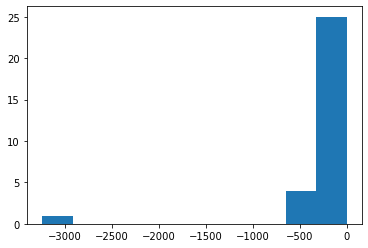

In [143]:
plt.hist(T)

In [186]:
T = -np.array([1,3,4,23,42,3,5,3245,2,5,454,35,4,54,5,435,4,35,4,35,4,35,64,35,4,6,53,6,435,453])
N = list(T)
AA = np.argsort(T[::-1][:10])
# print(N)
print(np.shape(N))
# print(np.shape(np.array(N)))
P =np.reshape(N,(30,1))
print(np.size(P))
# print(P.shape[1]==1)
if sum(np.shape(N))!= len(N):
    print("YESS")
# print(np.shape(P.ravel()))

(30,)
30


In [179]:
if sum(np.shape(np.array(P)))!= len(P):
    print("YESS")

YESS


In [180]:
print(sum(np.shape(P)))

31


In [181]:
print(sum(len(P)))

TypeError: 'int' object is not iterable

In [183]:
A =list(np.random.rand(100,2))
# print(np.array(A))
B = np.array(A)[:,1]
print(B)
print(np.argsort(B[::-1][:10]))

[0.28436246 0.4401201  0.8245888  0.03787975 0.87922906 0.75058513
 0.45010734 0.72933764 0.21954398 0.65741418 0.33771372 0.07086556
 0.22124579 0.74512884 0.4462474  0.03596581 0.64933587 0.16709839
 0.79359597 0.1088665  0.24851726 0.69206415 0.3692071  0.4895703
 0.0663053  0.26649522 0.42193161 0.17885045 0.05294163 0.31056646
 0.5445745  0.15034996 0.5583093  0.54462138 0.99604134 0.44137978
 0.69608749 0.26894302 0.85127688 0.22919104 0.39148069 0.63401424
 0.94734671 0.08855134 0.69589038 0.66741008 0.18193347 0.34837943
 0.26455697 0.34837797 0.76955941 0.57541399 0.95089222 0.74478221
 0.73638914 0.8956822  0.71152876 0.29999065 0.3450945  0.99777628
 0.2987224  0.75672655 0.22087926 0.91819612 0.60779992 0.48348047
 0.49219926 0.03452335 0.66127736 0.88317808 0.07953312 0.89896429
 0.56774346 0.01253743 0.03641893 0.16042652 0.96198756 0.00376753
 0.84088961 0.00854939 0.87547254 0.59812593 0.87047888 0.48187534
 0.96391367 0.61919607 0.0192878  0.40860852 0.68654593 0.86129

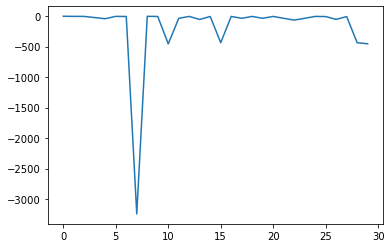

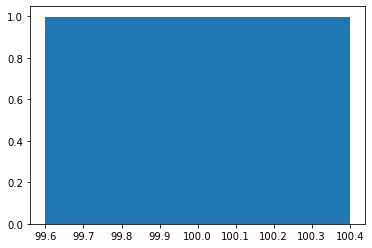

In [193]:
f = plt.figure(1)
plt.plot(np.arange(30),T)
g = plt.figure(2)
plt.bar(len(B),B)
plt.show()

In [8]:
import numpy as np
AAA = np.zeros(4)
AAA[4]= 1
print(AAA)

IndexError: index 4 is out of bounds for axis 0 with size 4